In [1]:
import pandas as pd
import os

# 1. Setup File Paths
input_filename = 'winequality-red.csv'
output_filename = 'winequality_red_cleaned.csv'

# 2. Define Correct Column Names

column_names = [
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
    "pH", "sulphates", "alcohol", "quality"
]

# 3. Load and Clean Data
if os.path.exists(input_filename):
    print("Loading dataset...")
    # 'sep=;' is required as the data uses semicolons, not commas.
    # 'skiprows=1' skips the messed up header row.
    data = pd.read_csv(input_filename, sep=';', skiprows=1, names=column_names)
    
    print(f"Original shape: {data.shape}")
    
    # Check for missing values
    missing_count = data.isnull().sum().sum()
    print(f"Missing values detected: {missing_count}")
    # Remove Duplicates
    duplicates = data.duplicated().sum()
    data_cleaned = data.drop_duplicates()
    print(f"Duplicate rows removed: {duplicates}")
    print(f"New shape: {data_cleaned.shape}")
    # 4. Save Cleaned Data
    data_cleaned.to_csv(output_filename, index=False)

else:
    print(f"Error: The file '{input_filename}' was not found.")

Loading dataset...
Original shape: (1599, 12)
Missing values detected: 0
Duplicate rows removed: 240
New shape: (1359, 12)


Loaded cleaned dataset.


C:\Users\prito\AppData\Local\Temp\ipykernel_3052\3680069043.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=data, palette='viridis')


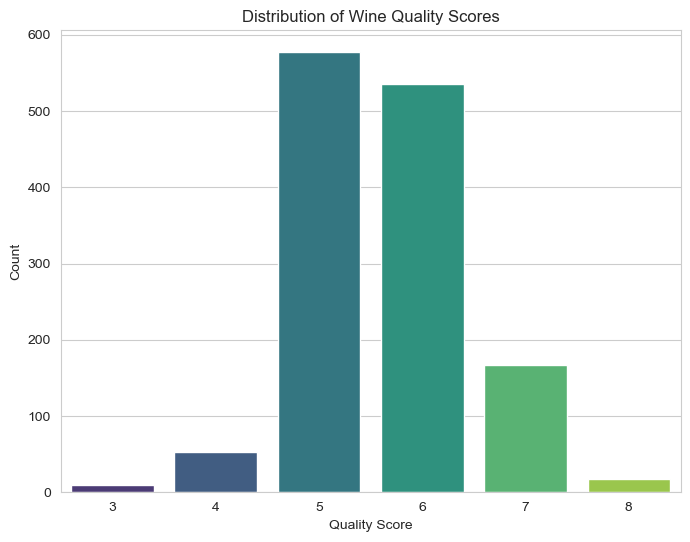

Observation: The dataset is imbalanced. Most wines are '5' or '6'.


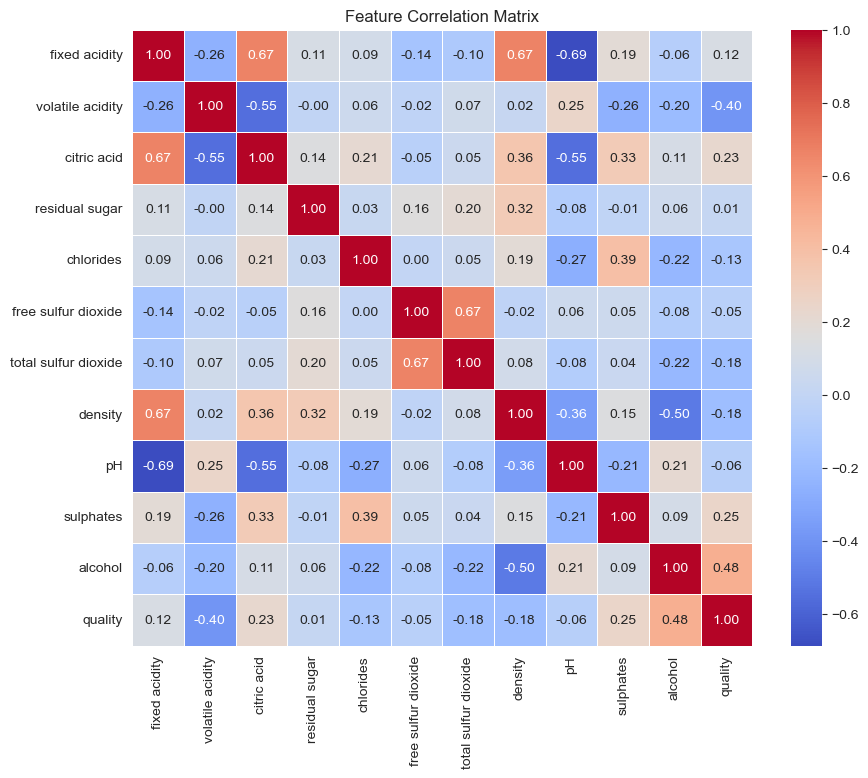

Observation: Alcohol has a strong positive correlation with Quality.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# 1. SETUP & DATA LOADING
if os.path.exists('winequality_red_cleaned.csv'):
    data = pd.read_csv('winequality_red_cleaned.csv')
    print("Loaded cleaned dataset.")
elif os.path.exists('winequality-red.csv'):
    data = pd.read_csv('winequality-red.csv', sep=';')
    data.columns = data.columns.str.replace('"', '').str.strip()
    print("Loaded and cleaned raw dataset.")
else:
    print("Error: Dataset not found. Please ensure the CSV file is in the folder.")
    exit()

# Set visual style
sns.set_style("whitegrid")

# 2. VISUALIZATION
# A. Class Distribution (Target Variable)
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=data, palette='viridis')
plt.title('Distribution of Wine Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.savefig('distribution_quality.png') # Saves image for your report
plt.show()
print("Observation: The dataset is imbalanced. Most wines are '5' or '6'.")

# B. Feature Correlation Matrix 
# Show relationships between physicochemical properties
plt.figure(figsize=(10, 8))
# Select only numeric columns to avoid errors
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()
print("Observation: Alcohol has a strong positive correlation with Quality.")


Loaded cleaned data: winequality_red_cleaned.csv

--- Preprocessing ---
Training samples: 1087
Testing samples: 272

--- Training ANN with Hyperparameter Tuning ---
Running Grid Search...
Best Parameters Found: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'max_iter': 3000, 'solver': 'adam'}
Best Cross-Validation Accuracy: 0.5474

Final Test Set Accuracy: 0.5588

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.18      0.18      0.18        11
           5       0.65      0.66      0.66       116
           6       0.58      0.56      0.57       107
           7       0.36      0.39      0.38        33
           8       0.00      0.00      0.00         3

    accuracy                           0.56       272
   macro avg       0.30      0.30      0.30       272
weighted avg       0.56      0.56      0.56       272



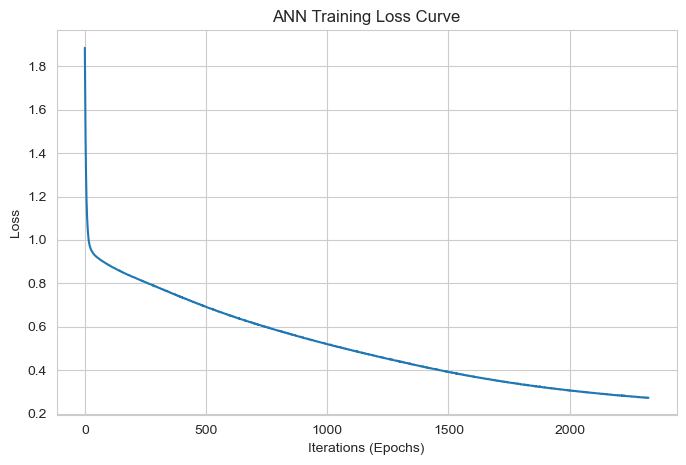

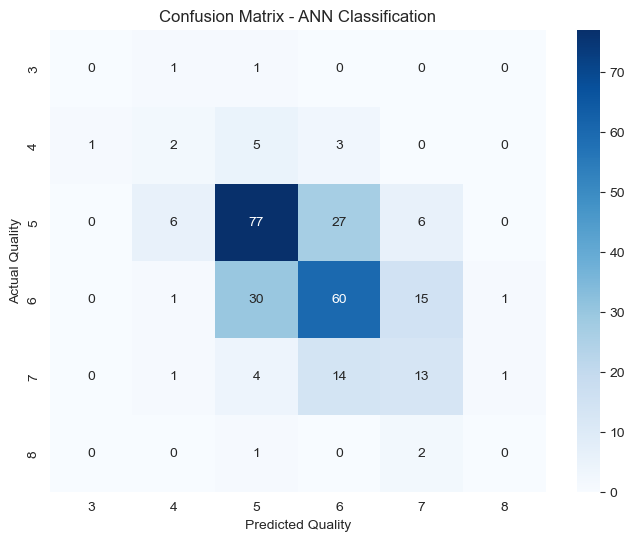

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# 1. LOAD DATA (Robust Check)
files_to_check = ['winequality_red_cleaned.csv', 'winequality-red.csv']
data = None

for f in files_to_check:
    if os.path.exists(f):
        if 'cleaned' in f:
            data = pd.read_csv(f)
            print(f"Loaded cleaned data: {f}")
        else:
            # Fallback to raw file if cleaned one is missing
            data = pd.read_csv(f, sep=';')
            data.columns = data.columns.str.replace('"', '').str.strip()
            print(f"Loaded raw data: {f}")
        break

if data is None:
    print("Error: Could not find dataset. Please ensure the CSV is in the folder.")
    exit()

# 2. PREPROCESSING (Methods Section)

print("\n--- Preprocessing ---")

# Separate Features (X) and Target (y)
X = data.drop('quality', axis=1)
y = data['quality']

# Feature Normalization 
# Scales data to Mean=0, Variance=1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# 3. MODEL TRAINING & TUNING (Methods Section)

print("\n--- Training ANN with Hyperparameter Tuning ---")
print("Running Grid Search...")

# We define a 'grid' of settings to test.
# The computer will try every combination to find the best one.
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)], # Network Structure
    'activation': ['relu', 'tanh'],                       # Activation Function
    'solver': ['adam'],                                   # Optimizer
    'alpha': [0.0001, 0.05],                              # Regularization (avoids overfitting)
    'max_iter': [3000]                                    # Max epochs
}

mlp = MLPClassifier(random_state=42)
clf = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)

print(f"Best Parameters Found: {clf.best_params_}")
print(f"Best Cross-Validation Accuracy: {clf.best_score_:.4f}")


# 4. FINAL EVALUATION (Results Section)
# Get the best model from the search
best_model = clf.best_estimator_

# Predict on the unseen Test set
y_pred = best_model.predict(X_test)

# Calculate Accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Set Accuracy: {test_acc:.4f}")

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# 5. VISUALIZATIONS (Analysis Section)

# A. Loss Curve
# Shows how the error decreased during training (Convergence)
plt.figure(figsize=(8, 5))
plt.plot(best_model.loss_curve_)
plt.title('ANN Training Loss Curve')
plt.xlabel('Iterations (Epochs)')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('ann_loss_curve.png') # Save for report
plt.show()

# B. Confusion Matrix
# Visualizes which classes were confused (e.g., predicting 5 when it was 6)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - ANN Classification')
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.savefig('ann_confusion_matrix.png') # Save for report
plt.show()
